In [ ]:
G = load_network('A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.50_prs_0.02.net')

In [1]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from infomap import Infomap
import numpy as np
import community as community_louvain
import leidenalg as la
import igraph as ig

def load_network(file_path):
    # Load a network from a Pajek .net file
    G = nx.read_pajek(file_path)
    # Convert the network to an undirected graph, if necessary
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()
    # Pajek files often label nodes with strings, ensure they are consistent integers if needed
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    return G

def detect_communities(G, method='louvain'):
    if method == 'louvain':
        partition = community_louvain.best_partition(G)
    elif method == 'infomap':
        infomap = Infomap()
        # Ensure that node labels are converted to integers if they are not already
        for edge in G.edges():
            u, v = map(int, edge)  # Convert edge endpoints to integers
            infomap.add_link(u, v)
        infomap.run()
        # Mapping node to module with proper node type handling
        partition = {int(node): module for node, module in infomap.get_modules().items()}
    elif method == 'agglomerative':
        partition = community_louvain.best_partition(G, resolution=1.0)
    elif method == 'leiden':
        # Convert NetworkX graph to an igraph graph
        ig_graph = ig.Graph.TupleList(G.edges(), directed=False)
        partition = la.find_partition(ig_graph, la.ModularityVertexPartition)
        # Convert partition to the same format used in NetworkX
        partition = {node.index: partition.membership[node.index] for node in ig_graph.vs}
    else:
        raise ValueError("Unsupported method: Choose 'louvain' or 'infomap'")
    return partition

def calculate_metrics(true_partition, detected_partition):
    # Convert partition dictionaries to lists of community labels
    true_labels = [true_partition[node] for node in sorted(true_partition)]
    detected_labels = [detected_partition[node] for node in sorted(detected_partition)]
    nmi = normalized_mutual_info_score(true_labels, detected_labels)
    ari = adjusted_rand_score(true_labels, detected_labels)
    return nmi, ari

In [2]:
# Example usage
G = load_network('A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.50_prs_0.02.net')
true_partition = {node: node // 60 for node in G.nodes()}  # Example true partition logic
louvain_partition = detect_communities(G, 'louvain')
infomap_partition = detect_communities(G, 'infomap')
ag_partition = detect_communities(G, 'agglomerative')
leiden_partition = detect_communities(G, 'leiden')

nmi_louvain, ari_louvain = calculate_metrics(true_partition, louvain_partition)
nmi_infomap, ari_infomap = calculate_metrics(true_partition, infomap_partition)
nmi_ag, ari_ag = calculate_metrics(true_partition, ag_partition)
nmi_leiden, ari_leiden = calculate_metrics(true_partition, leiden_partition)

print("NMI (Louvain):", nmi_louvain, "ARI (Louvain):", ari_louvain)
print("NMI (Infomap):", nmi_infomap, "ARI (Infomap):", ari_infomap)
print("NMI (Agglomerative):", nmi_infomap, "ARI (Agglomerative):", ari_ag)
print("NMI (Leiden):", nmi_leiden, "ARI (Leiden):", ari_leiden)

#visualize_communities(G, louvain_partition, "Louvain Method")
# visualize_communities(G, infomap_partition, "Infomap Method")

NMI (Louvain): 1.0 ARI (Louvain): 1.0
NMI (Infomap): 1.0 ARI (Infomap): 1.0
NMI (Agglomerative): 1.0 ARI (Agglomerative): 1.0
NMI (Leiden): 0.23860607266374959 ARI (Leiden): 0.18619632768361583


In [ ]:
def visualize_communities(G, partition, title):
#     if "Infomap" in title:
    if not all(node in partition for node in G.nodes()):
        missing_nodes = [node for node in G.nodes() if node not in partition]
        print(f"Warning: Nodes missing in partition: {missing_nodes}")
        for node in missing_nodes:
            partition[node] = -1  # Assigning a default community for missing nodes
        
        
    
    # Ensure node labels are consistent for mapping colors
    unique_communities = list(set(partition.values()))
    community_index = {comm: idx for idx, comm in enumerate(unique_communities)}
    colors = [community_index[partition[node]] for node in G.nodes()]

    # Generate position map for consistent node positions
    pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for reproducible layout

    # Create a new figure and Axes for drawing
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.get_cmap('viridis', len(unique_communities))
    
    # Drawing the nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, cmap=cmap, node_size=40, alpha=0.8)
    
    # Drawing the edges
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)

    # Setting up the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.05)
    cbar.set_label('Community ID')
    
#     if "Infomap" in title:
#         cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.05)
#         cbar.set_label('Community ID')
#     else:
#         cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(min(colors), max(colors), len(unique_communities)), 
#                             boundaries=np.arange(min(colors)-0.5, max(colors)+1.5), spacing='proportional',
#                             label='Community ID')

    ax.set_title(title)
    ax.axis('off')  # Turn off the axis
    
    plt.show()

visualize_communities(G, louvain_partition, "Community Structure Detected by Louvain")
visualize_communities(G, infomap_partition, "Community Structure Detected by Infomap")
visualize_communities(G, ag_partition, "Community Structure Detected by Agglomerative Greedy")
visualize_communities(G, leiden_partition, "Community Structure Detected by Leiden")

In [ ]:
import networkx as nx

def girvan_newman_community_detection(G, num_communities=2):
    from networkx.algorithms.community import girvan_newman
    communities_generator = girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    # Choose the level of communities to return based on your num_communities parameter
    if num_communities == 2:
        return {node: idx for idx, community in enumerate(top_level_communities) for node in community}
    else:
        return {node: idx for idx, community in enumerate(next_level_communities) for node in community}

# Example usage
# Adjust num_communities based on how many splits you want to examine initially
gn_partition = girvan_newman_community_detection(G, num_communities=2)
visualize_communities(G, gn_partition, "Community Structure Detected by Girvan-Newman")


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def create_distance_matrix(G):
    """ Create a distance matrix for the graph where distance is the shortest path between nodes."""
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    size = len(G)
    distance_matrix = np.zeros((size, size))
    for u, distances in path_length.items():
        for v, d in distances.items():
            distance_matrix[u][v] = d
    return distance_matrix

def perform_hierarchical_clustering(G):
    # Create a distance matrix
    distance_matrix = create_distance_matrix(G)
    # Convert to condensed distance matrix required by linkage
    condensed_matrix = squareform(distance_matrix)
    # Generate the linkage matrix
    Z = linkage(condensed_matrix, method='average')
    return Z

def plot_dendrogram(Z, labels=None):
    """ Plot a dendrogram to visualize the hierarchical clustering """
    plt.figure(figsize=(10, 8))
    dendrogram(Z, labels=labels)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Node')
    plt.ylabel('Distance')
    plt.show()

# Example usage
# G2 = nx.karate_club_graph()
Z = perform_hierarchical_clustering(G)
plot_dendrogram(Z, labels=[str(node) for node in G.nodes()])


In [ ]:
from scipy.cluster.hierarchy import inconsistent, fcluster

def auto_cluster_cut(Z):
    # Calculate the inconsistency
    depth = 3
    incons = inconsistent(Z, depth)
    # Set a threshold for inconsistency
    threshold = 1.5
    clusters = fcluster(Z, threshold, criterion='inconsistent')
    return clusters

clusters = auto_cluster_cut(Z)
print("Automatic cluster assignments:", clusters)

In [3]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

def assign_communities_from_dendrogram(Z, G, cutoff):
    # Determine clusters from the linkage matrix Z at a given cutoff
    clusters = fcluster(Z, cutoff, criterion='distance')
    # Create a partition dictionary mapping nodes to their cluster
    partition = {node: clusters[i] for i, node in enumerate(G.nodes())}
    return partition

def visualize_communities(G, partition, title):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Mapping of node to community index
    community_index = {node: community for node, community in partition.items()}

    # Generate colors based on community index
    colors = [community_index.get(node, 0) for node in G.nodes()]
    
    # Generate position map for consistent node positions
    pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for reproducible layout
    cmap = plt.get_cmap('viridis', max(community_index.values()) + 1)

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cmap, node_size=40, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)

    # Set up the colorbar properly
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(community_index.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.015, pad=0.05)
    cbar.set_label('Community ID')

    ax.set_title(title)
    ax.axis('off')  # Turn off the axis
    plt.show()



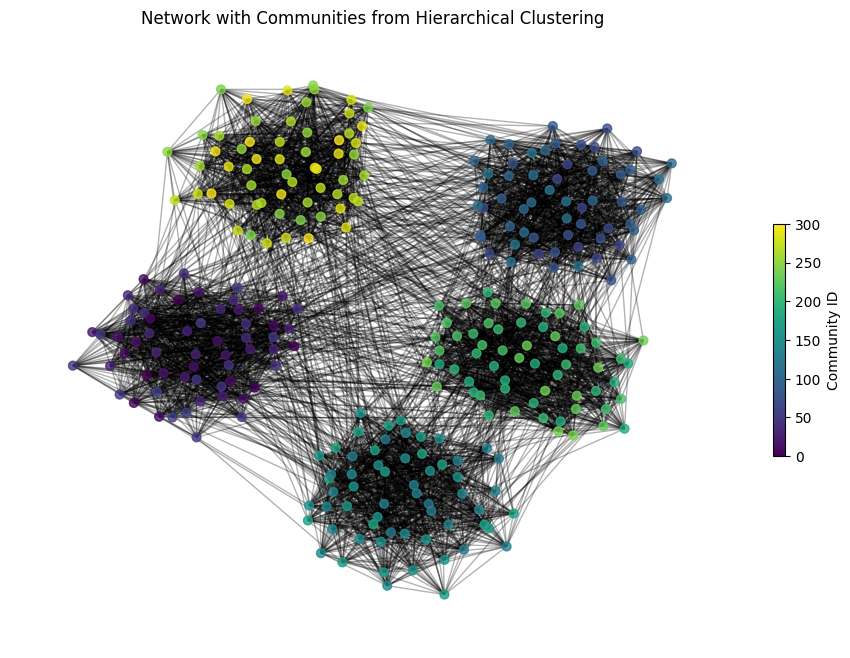

In [4]:
# Example usage
# G = nx.karate_club_graph()  # Your example graph
linkage_matrix = linkage(pdist(nx.to_numpy_array(G)), method='ward')

# Assign communities using a chosen cutoff
cutoff = 1.5  # Adjust this based on your dendrogram analysis
partition = assign_communities_from_dendrogram(linkage_matrix, G, cutoff)

# Visualize the network with communities
visualize_communities(G, partition, "Network with Communities from Hierarchical Clustering")